<a href="https://colab.research.google.com/gist/ykerus/923fbbd18728de8c19497fd94a186eba/nlp1-practical-i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical 1: Sentiment Detection of Movie Reviews
========================================



This practical concerns sentiment detection of movie reviews.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task (how might one go about classifying the texts?); you will write
code that decides whether a random unseen movie review is positive or
negative.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Bo Pang’s system. If you have questions about it,
we should resolve them in our first demonstrated practical.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Environment**

All code should be written in **Python 3**. 
If you use Colab, check if you have that version with `Runtime -> Change runtime type` in the top menu.

> If you want to work in your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.

#### Learning Python 3

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

Loading the Data
-------------------------------------------------------------

In [0]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2019-11-13 21:13:34--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.4’

sent_lexicon.4      100%[===================>] 647.05K  --.-KB/s    in 0.06s   

2019-11-13 21:13:34 (9.75 MB/s) - ‘sent_lexicon.4’ saved [662577/662577]

--2019-11-13 21:13:37--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)

In [0]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import copy

In [0]:
# load reviews into memory
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# For documentation on POS-tags, see 
# https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print(len(reviews))

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
    
print("#types", len(c))

print("Most common tokens:")
for token, count in c.most_common(25):
  print("%10s : %8d" % (token, count))
  

2000
0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
#types 47743
Most common tokens:
       

Symbolic approach – sentiment lexicon (2pts)
---------------------------------------------------------------------



**How** could one automatically classify movie reviews according to their
sentiment? 

If we had access to a **sentiment lexicon**, then there are ways to solve
the problem without using Machine Learning. One might simply look up
every open-class word in the lexicon, and compute a binary score
$S_{binary}$ by counting how many words match either a positive, or a
negative word entry in the sentiment lexicon $SLex$.

$$S_{binary}(w_1w_2...w_n) = \sum_{i = 1}^{n}\text{sgn}(SLex\big[w_i\big])$$

**Threshold.** In average there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1w_2...w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{else }
        \end{array}
$$

To implement this approach, you should use the sentiment
lexicon in `sent_lexicon`, which was taken from the
following work:

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

#### (Q: 1.1) Implement this approach and report its classification accuracy. (1 pt)

In [0]:
# YOUR CODE HERE

#read sent_lexicon file
dic = {} #holds words, sentiments and strengths
sent_lex = open("sent_lexicon", mode="r", encoding="utf-8")
line = sent_lex.readline()

while line:
  split = line.split()
  strength = split[0][5:]
  word = split[2][6:]
  polarity = split[5][14:]
  dic[word] = [polarity,strength]
  line = sent_lex.readline()

sent_lex.close()

In [0]:
# YOUR CODE HERE

def classify(S, thresh):
  if S > thresh:
    return "POS"
  else:
    return "NEG"

In [0]:
# YOUR CODE HERE

threshhold = 8 #positive bias
labels  = [] #ground-truth
results = [] #prediction

for i, r in enumerate(reviews): 
  Sbin = 0
  labels.append(r["sentiment"])
  for line in r["content"]: #line=sentence
    for word, _ in line:
      word = word.lower() #make sure the're non-capital letters
      if word in dic: #alternative: ... and dic.get(word)[0] != "neutral"
        #alternative: sign = (dic.get(word)[0] == "positive")*2-1
        if dic[word][0] == "positive": #could be pos, neg, or neutral
          Sbin += 1
        elif dic[word][0] == "negative":
          Sbin -= 1
  results.append(classify(Sbin, threshhold)) #bias included
correct = [labels[i]==results[i] for i in range(len(reviews))] #boolean

In [0]:
token_results = ["+" if correct[i] else "-" for i in range(len(reviews))] # YOUR CODE HERE
token_accuracy = np.sum(correct)/len(reviews) # YOUR CODE HERE
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


If the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we could take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Their lexicon also records two possible magnitudes of sentiment (*weak*
and *strong*), so you can implement both the binary and the weighted
solutions (please use a switch in your program). For the weighted
solution, you can choose the weights intuitively *once* before running
the experiment.

#### (Q: 1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [0]:
# YOUR CODE HERE

strong_weight = 3 #quick trial and error gives 1% accuracy gain
weak_weight = 1
#threshold dependent on weights?

results_mag = []

for i, r in enumerate(reviews): 
  Sbin = 0
  for line in r["content"]: #line=sentence
    for word, _ in line:
      word = word.lower() #make sure the're non-capital letters
      if word in dic:
        if dic[word][0] == "positive": #could be pos, neg, or neutral
          if dic[word][1] == "weaksubj": #only weak or strong
            Sbin += weak_weight
          else:
            Sbin += strong_weight
        elif dic[word][0] == "negative":
          if dic[word][1] == "weaksubj":
            Sbin -= weak_weight
          else:
            Sbin -= strong_weight
  results_mag.append(classify(Sbin, threshhold)) #bias included
correct_mag = [labels[i]==results_mag[i] for i in range(len(reviews))] #boolean

In [0]:

magnitude_results = ["+" if correct_mag[i] else "-" for i in range(len(reviews))]
magnitude_accuracy = np.sum(correct_mag)/len(reviews)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.69


#### Optional: make a barplot of the two results.

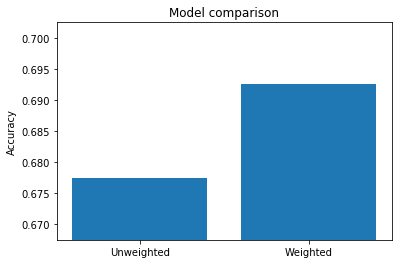

In [0]:
# YOUR CODE HERE
accuracies = [token_accuracy, magnitude_accuracy]
plt.bar(["Unweighted","Weighted"], accuracies)
plt.title("Model comparison")
plt.ylabel("Accuracy")
plt.ylim(min(accuracies)-.01,max(accuracies)+.01)
plt.show()

In [0]:
#save some RAM
dic, results, labels, accuracies, results_mag, correct_mag = "", "", "", "", "", ""

Answering questions in statistically significant ways (1pt)
-------------------------------------------------------------

Does using the magnitude improve the results? Oftentimes, answering questions like this about the performance of
different signals and/or algorithms by simply looking at the output
numbers is not enough. When dealing with natural language or human
ratings, it’s safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are really just
noise. 

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

In this experiment, $q = 0.5$. Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 


#### (Q 2.1): Implement the sign test. Is the difference between the two symbolic systems significant? What is the p-value? (1 pt)

You should use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.

You can quickly verify the correctness of
your sign test code using a [free online
tool](https://www.graphpad.com/quickcalcs/binomial1.cfm).

In [0]:
from decimal import Decimal
from scipy.special import comb


def sign_test(results_1, results_2):
  """test for significance
  results_1 is a list of classification results (+ for correct, - incorrect)
  results_2 is a list of classification results (+ for correct, - incorrect)
  """
  ties, plus, minus = 0, 0, 0

  # "-" carries the error
  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]=="-": 
      plus += 1
    elif results_2[i]=="-": 
      minus += 1

  n = 2*np.ceil(ties/2.) + plus + minus # YOUR CODE HERE
  k = np.ceil(ties/2.) + min(plus,minus) # YOUR CODE HERE

  summation = Decimal(0.0)
  for i in range(0,int(k)+1):
      #the equation simplifies to this for q=0.5
      summation += Decimal(comb(n,i,exact=True)) # YOUR CODE HERE

  # use two-tailed version of test
  summation *= 2
  summation *= (Decimal(0.5)**Decimal(n))

  print("The difference is", 
        "not significant" if summation >= 0.05 else "significant")
  
  return summation

p_value = sign_test(token_results, magnitude_results)
print("p-value =", round(p_value,3))

The difference is not significant
p-value = 0.517


## Using the Sign test

**From now on, report all differences between systems using the
sign test.** You can think about a change that you apply to one system, as a
 new system.
    
You should report statistical test
results in an appropriate form – if there are several different methods
(i.e., systems) to compare, tests can only be applied to pairs of them
at a time. This creates a triangular matrix of test results in the
general case. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


Naive Bayes (8pt + 1pt bonus)
==========


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described in Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing text information as vectors (or points in space), making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text.

## Writing your own classifier

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you a position to replicate
    Pang et al., Naive Bayes results. However, the numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. You will find the
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, and store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.

#### (Q3.1) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining reviews cv900–cv999.  Report results using simple classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [0]:
# YOUR CODE HERE

#some helpful functions
def extract_vocabulary(data, ng):
  vocabulary = []
  for r in data:
    for sentence in r["content"]:
      for word, _ in sentence:
        vocabulary.append(word.lower())
  if ng == 1:
    return np.unique(vocabulary)
  #else
  ngram = ngrams(vocabulary, ng) #could do padding, but small/no difference
  return np.unique([" ".join(g) for g in ngram]) #combinations are space separated

def extract_tokens(doc):
  W = []
  for sentence in doc["content"]:
    for word, _ in sentence:
      W.append(word.lower())
  return W

def count_docs_in_class(data, c):
  count = 0
  for r in data:
    if r["sentiment"] == c:
      count += 1
  return count

def concatenate_text(data, c, ng):
  text = []
  for r in data:
    if r["sentiment"] == c:
      for sentence in r["content"]:
        for word, _ in sentence:
          text.append(word.lower())
  if ng == 1:
    return text
  #else
  ngram = ngrams(text, ng)
  return [" ".join(g) for g in ngram]

def get_condprob(Tct, tot_count, k, Vsize):
    return (Tct + k) / (tot_count + k*Vsize)

In [0]:
# YOUR CODE HERE

#k for smoothing
#ng for ngrams (ng=1 trains on unigrams, ng=2 on bigrams, etc)
#combine the models later for classification using interpolation

#algorithm from:
#https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html
def train_NaiveBayes(C, D, k, ng):
  V = extract_vocabulary(D, ng)
  N = len(D)
  prior = np.zeros(len(C))
  tot_counts = np.zeros(len(C))
  #create condprob dictionary, for all tokens t in V and classes c
  condprob = {} #use: condprob[t][c] 
  for t in V:
    condprob[t] = np.zeros(len(C))
  for c in range(len(C)): #c is index
    Nc = count_docs_in_class(D, C[c])
    prior[c] = Nc/N
    text_c = concatenate_text(D, C[c], ng) #all tokens are also in vocabulary
                                         # ^ not the other way around!
    unique_c, counts_c = np.unique(text_c, return_counts=True)
    Tc = dict(zip(unique_c, counts_c)) #counting tokens a different way takes lot of time
    tot_counts[c] = np.sum([Tc.get(t,0) for t in V])
    for t in V: #t is token (could be combination of ng words)
      condprob[t][c] = get_condprob(Tc.get(t, 0), tot_counts[c], k, len(V))
  return V, prior, condprob

#vocabulary and condprob are lists for ngram application
#params, also list, carries weitght of each ngram model
#where sum(params) = 1 (constraint)
def apply_NaiveBayes(C, prior, condprobs, review, params):
  ng = len(params)
  score = np.zeros(len(C)) 
  W = extract_tokens(review)
  for c in range(len(C)): #c is index
    logZero = False #assuming prior is not zero
    score[c] = np.log(prior[c])
    for i, t in enumerate(W):
      par1xPuni = params[0]*condprobs[0].get(t,-np.ones(len(C)))[c] #P unigram, ignore (=-1) if word not in vocab
      #P bigram, don't count (=0) if not in vocab or previous word does not exist (edge case)
      par2xPbi = params[1]*condprobs[1].get(W[i-1]+" "+t,np.zeros(len(C)))[c] if ng>1 and i>0 and par1xPuni>=0 else 0 
      #P trigram, don't count (=0) if not in vocab or previous 2 words don't exist (edge case)
      par3xPtri = params[2]*condprobs[2].get(W[i-2]+" "+W[i-1]+" "+t,np.zeros(len(C)))[c] if ng>2 and i>1 and par1xPuni>=0 else 0
    #here we combine the models (only if token t is in the vocab)
    #ˆP(w_n|w_n-2,w_n-1) = par1*P(w_n|w_n-2,w_n-1) + par2*P(w_n|w_n-1) + par3*P(w_n) 
      condprob_tc = par1xPuni + par2xPbi + par3xPtri if par1xPuni>=0 else 1 #ignore if t is not in vocab
      if condprob_tc == 0: #only for k=0 (no smoothing)
        score[c] = 0
        logZero = True
        break
      else:
        score[c] += np.log(condprob_tc) 
    if logZero:
      break
  return C[list(score).index(np.max(score))] #0 index if scores are equal

In [0]:
# YOUR CODE HERE

train_set = [r for r in reviews if r["cv"] < 900]
test_set  = [r for r in reviews if r["cv"] >= 900]

k = 0 #smoothing parameter
ng = 1 #ngram parameter
params = [1] #ngram model weight

C = ["POS","NEG"]
V_NB, prior, condprob = train_NaiveBayes(C, train_set, k, ng)

In [0]:
# YOUR CODE HERE

labels_NB = []
results_NB = []
for r in test_set:
  labels_NB.append(r["sentiment"])
  results_NB.append(apply_NaiveBayes(C, prior, [condprob], r, params))
correct_NB = [labels_NB[i]==results_NB[i] for i in range(len(test_set))] #boolean

In [0]:
# YOUR CODE HERE

#without smoothing
NB_results = ["+" if correct_NB[i] else "-" for i in range(len(test_set))]
NB_accuracy = np.sum(correct_NB)/len(test_set)
print("Accuracy: %0.2f" % NB_accuracy)

Accuracy: 0.49


In [0]:
#accuracy ~50%, because almost all probabilities become zero due to zero condprob
#this is the case because we don't apply smooothing
#the scores for both classes is then zero and the first (POS) will be picked 
print(C)
print(np.sum(np.array(results_NB)=="POS"),", ",np.sum(np.array(results_NB)=="NEG"))

['POS', 'NEG']
191 ,  9


In [0]:
#save some RAM
results_NB, correct_NB = "", ""

#### (Bonus Questions) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

You can simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [0]:
# YOUR CODE HERE

# No, without too much effort, a classifier could simply return "positive" in any case
# and still get an accuracy of 0.9! An accuracy of 0.9 sounds really good, but in
# this case it doesn't say anything about how well the classifier can separate
# between positive and negative reviews.

## Smoothing

The presence of words in the test dataset that
haven’t been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.2) Implement Laplace feature smoothing (1pt)
($smoothing(\cdot) = \kappa$, constant for all words) in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [0]:
# YOUR CODE HERE

k = 1 #smoothing parameter
ng = 1 #ngram parameter
params = [1]

V_NBs, prior, condprob = train_NaiveBayes(C, train_set, k, ng)

In [0]:
# YOUR CODE HERE

results_NBs = [] #s for smooth, labels are the same as above

for r in test_set:
  results_NBs.append(apply_NaiveBayes(C, prior, [condprob], r, params))
correct_NBs = [labels_NB[i]==results_NBs[i] for i in range(len(test_set))] #boolean

In [0]:
# YOUR CODE HERE

NBs_results = ["+" if correct_NBs[i] else "-" for i in range(len(test_set))]
NBs_accuracy = np.sum(correct_NBs)/len(test_set)
print("Accuracy: %0.2f" % NBs_accuracy)
#much better!

Accuracy: 0.82


#### (Q3.3) Is the difference between non smoothed (Q3.1) and smoothed (Q3.2) statistically significant? (0.5pt)

In [0]:
# YOUR CODE HERE

p_value = sign_test(NB_results, NBs_results)
print("p-value =", round(p_value,7))

The difference is significant
p-value = 0.0000035


In [0]:
#save some RAM
train_set, test_set, labels_NB, results_NBs, correct_NBs = "", "", "", "", ""

## Cross-validation

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is that we
end up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that’s better
and better on our data, but worse and worse at generalizing to new,
never-before seen data.

A simple method to guard against Type III errors is to use
cross-validation. In N-fold cross-validation, we divide the data into N
distinct chunks / folds. Then, we repeat the experiment N times, each
time holding out one of the chunks for testing, training our classifier
on the remaining N - 1 data chunks, and reporting performance on the
held-out chunk. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)

#### (Q3.4) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)






In [0]:
# YOUR CODE HERE

def perform_cv(C, splits, n, k, params):
  ng = len(params)
  correct_cv = []
  accuracies_cv = []
  V_avg = 0 #avg vocabulary size
  for i in range(n): #split i is test-set
    train_set = [] #the rest is train-set
    for j in range(n):
      if j != i:
        train_set += splits[j]
    condprobs = [] #will hold condprobs for each ngram model
    for ngi in range(1,ng+1): #loop over ngrams
      #train separate model for each ngram, combine probabilities as such:
      #ˆP(w_n|w_n-2,w_n-1) = par1*P(w_n|w_n-2,w_n-1) + par2*P(w_n|w_n-1) + par3*P(w_n)
      #(see function apply_NaiveBayes())
      V, prior, condprob = train_NaiveBayes(C, train_set, k, ngi) #prior same for all ng (in this case)
      condprobs.append(copy.deepcopy(condprob))
      V_avg += len(V)/n 
    labels_cv = []
    results_cv = []
    for r in splits[i]:
      labels_cv.append(r["sentiment"])
      results_cv.append(apply_NaiveBayes(C, prior, condprobs, r, params))
    correct_cv.append([labels_cv[j]==results_cv[j] for j in range(len(splits[i]))])
    accuracies_cv.append(np.sum(correct_cv[i])/len(splits[i]))
    print("Finished: {} / {} -- Accuracy: {} -- Avg acc: {}".format(i+1,n,round(accuracies_cv[i],2),round(np.mean(accuracies_cv),2)))
  return correct_cv, accuracies_cv, V_avg
  #return avg vocabulary size to compare for different methods


In [0]:
# YOUR CODE HERE
n = 10
splits = [[] for i in range(n)] #use: splits[i] where i = 0,..,9
for r in reviews:
  splits[r["cv"] % n].append(r)

In [0]:
# YOUR CODE HERE

k = 1
params = [1] #determines the weight of each ngram (only unigrams in this case)
#params implicitly provides ngram parameter ng (=len(params))

correct_cv, accuracies_cv, Vavg_cv = perform_cv(C, splits, n, k, params)

Finished: 1 / 10 -- Accuracy: 0.79 -- Avg acc: 0.79
Finished: 2 / 10 -- Accuracy: 0.84 -- Avg acc: 0.81
Finished: 3 / 10 -- Accuracy: 0.8 -- Avg acc: 0.81
Finished: 4 / 10 -- Accuracy: 0.82 -- Avg acc: 0.81
Finished: 5 / 10 -- Accuracy: 0.78 -- Avg acc: 0.81
Finished: 6 / 10 -- Accuracy: 0.84 -- Avg acc: 0.81
Finished: 7 / 10 -- Accuracy: 0.83 -- Avg acc: 0.82
Finished: 8 / 10 -- Accuracy: 0.78 -- Avg acc: 0.81
Finished: 9 / 10 -- Accuracy: 0.83 -- Avg acc: 0.81
Finished: 10 / 10 -- Accuracy: 0.84 -- Avg acc: 0.82


In [0]:
#cross-validation accuracy
#averaged over all splits
cv_results = []
for c in correct_cv:
  cv_results += ["+" if c[i] else "-" for i in range(len(c))]
cv_accuracy = np.sum(accuracies_cv)/n
print("Accuracy: %0.2f" %cv_accuracy)

Accuracy: 0.82


#### (Q3.5) Write code to calculate and report variance, in addition to the final performance. (1pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [0]:
# YOUR CODE HERE
#cross-validation variance (and std)
#cross-validation accuracy
#averaged over all splits/folds
cv_var = np.var(accuracies_cv)
cv_std = round(np.sqrt(cv_var),4) #=np.std(accuracies_cv)
print("Variance: %0.4f" %cv_var)
print("Stddev  : %0.3f" %cv_std)
print("Accuracy: %0.2f" %cv_accuracy)

Variance: 0.0006
Stddev  : 0.025
Accuracy: 0.82


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

#### (Q3.6): A touch of linguistics (1pt)

Taking a step further, you can use stemming to
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.
 Also, you should do cross validation and concatenate the predictions from all folds to compute the significance.

In [0]:
# YOUR CODE HERE

stemmer = PorterStemmer()
reviews_stem = copy.deepcopy(reviews) #stemmed reviews
#replace all words by their stem
for ri, r in enumerate(reviews):
  for si, s in enumerate(r["content"]):
    for ti, t in enumerate(s):
      reviews_stem[ri]["content"][si][ti][0] = stemmer.stem(t[0])

In [0]:
#now same as above but with stemmed reviews
splits_stem = [[] for i in range(n)]
for r in reviews_stem:
  splits_stem[r["cv"] % n].append(r)

In [0]:

params = [1] #weights of each ngram model into final result (interpolation params)
correct_stem, accuracies_stem, Vavg_stem = perform_cv(C, splits_stem, n, k, params) 

Finished: 1 / 10 -- Accuracy: 0.78 -- Avg acc: 0.78
Finished: 2 / 10 -- Accuracy: 0.84 -- Avg acc: 0.81
Finished: 3 / 10 -- Accuracy: 0.8 -- Avg acc: 0.81
Finished: 4 / 10 -- Accuracy: 0.84 -- Avg acc: 0.82
Finished: 5 / 10 -- Accuracy: 0.78 -- Avg acc: 0.81
Finished: 6 / 10 -- Accuracy: 0.84 -- Avg acc: 0.81
Finished: 7 / 10 -- Accuracy: 0.82 -- Avg acc: 0.81
Finished: 8 / 10 -- Accuracy: 0.78 -- Avg acc: 0.81
Finished: 9 / 10 -- Accuracy: 0.83 -- Avg acc: 0.81
Finished: 10 / 10 -- Accuracy: 0.83 -- Avg acc: 0.81


In [0]:
stem_results = []
for c in correct_stem:
  stem_results += ["+" if c[i] else "-" for i in range(len(c))]
  
stem_accuracy = np.sum(accuracies_stem)/n
stem_var = np.var(accuracies_stem)
stem_std = round(np.sqrt(stem_var),4) #=np.std(accuracies_stem)
print("Variance: %0.4f" %stem_var)
print("Stddev  : %0.3f" %stem_std)
print("Accuracy: %0.2f" %stem_accuracy)


Variance: 0.0007
Stddev  : 0.026
Accuracy: 0.81


#### (Q3.7): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (0.5pt)


In [0]:
# YOUR ANSWER HERE
p_value = sign_test(cv_results, stem_results)
print("p-value =",round(p_value,2))

The difference is not significant
p-value = 0.95


#### Q3.8: What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.2)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [0]:
# YOUR CODE HERE
# cross-val vocab size averaged over each iteration
print(" Method                   |  Vocabulary size\n"+"-"*70)
print(" NB smooth                |  {}".format(len(V_NBs)))
print(" NB smooth cross-val      |  {}  (averaged)".format(round(Vavg_cv)))
print(" NB smooth cross-val stem |  {}  (averaged)".format(round(Vavg_stem)))

 Method                   |  Vocabulary size
----------------------------------------------------------------------
 NB smooth                |  45348
 NB smooth cross-val      |  45446  (averaged)
 NB smooth cross-val stem |  32521  (averaged)


In [0]:
#Using stemming prior to training reduces our vocabulary size by more than 25%!
#Nevertheless, our accuracy does not decrease significantly, so stemming is a 
#good way to speed up the learning process while still getting a well performing model

In [0]:
correct_cv, reviews_stem, splits_stem, correct_stem, = "", "", "", ""

#### Q3.9: Putting some word order back in (0.5+0.5pt=1pt)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-grams** features. 
Retrain your classifier from (Q3.4) using **unigrams+bigrams** and
**unigrams+bigrams+trigrams** as features, and report accuracy and statistical significances (in comparison to the experiment at (Q3.4) for all 10 folds, and between the new systems).





In [0]:
#unigrams + bigrams

#account for sparsity bigrams model (bigram is highly sparse compared to unigram)
#occurances in the bigrams model are more sparse and therefore also 
#the conditional probabilities (by a factor ~1e-5, ~1e-6 some cases (checked by comparing condprobs))
params = [1e-6,1-1e-6] #weights of each ngram model into final result (interpolation params)
#params = [1,0] #gives unigram model; same results as above, but a bit slower (checks for bigrams as well, multiplies by 0)
#params = [0,1] #bigrams that are not in the vocab are given zero probability, so this will give accuracy 0.5
correct_n2, accuracies_n2, Vavg_n2 = perform_cv(C, splits, n, k, params)

Finished: 1 / 10 -- Accuracy: 0.8 -- Avg acc: 0.8
Finished: 2 / 10 -- Accuracy: 0.85 -- Avg acc: 0.82
Finished: 3 / 10 -- Accuracy: 0.83 -- Avg acc: 0.82
Finished: 4 / 10 -- Accuracy: 0.88 -- Avg acc: 0.84
Finished: 5 / 10 -- Accuracy: 0.83 -- Avg acc: 0.84
Finished: 6 / 10 -- Accuracy: 0.88 -- Avg acc: 0.84
Finished: 7 / 10 -- Accuracy: 0.84 -- Avg acc: 0.84
Finished: 8 / 10 -- Accuracy: 0.84 -- Avg acc: 0.84
Finished: 9 / 10 -- Accuracy: 0.86 -- Avg acc: 0.84
Finished: 10 / 10 -- Accuracy: 0.84 -- Avg acc: 0.84


In [0]:
n2_results = []
for c in correct_n2:
  n2_results += ["+" if c[i] else "-" for i in range(len(c))]
  
n2_accuracy = np.sum(accuracies_n2)/n
n2_var = np.var(accuracies_n2)
n2_std = round(np.sqrt(n2_var),4) #=np.std(accuracies_n2)
print("Variance: %0.4f" %n2_var)
print("Stddev  : %0.3f" %n2_std)
print("Accuracy: %0.2f" %n2_accuracy)

Variance: 0.0006
Stddev  : 0.024
Accuracy: 0.84


In [0]:
#unigrams + bigrams + trigrams

#again, account for sparsity (the ratio unigram - bigram is same as previously used)
params = [1e-10,1e-4-1e-10,1-1e-4] #weights of each ngram model into final result (interpolation params)
correct_n3, accuracies_n3, Vavg_n3 = perform_cv(C, splits, n, k, params)

Finished: 1 / 10 -- Accuracy: 0.81 -- Avg acc: 0.81
Finished: 2 / 10 -- Accuracy: 0.86 -- Avg acc: 0.84
Finished: 3 / 10 -- Accuracy: 0.84 -- Avg acc: 0.84
Finished: 4 / 10 -- Accuracy: 0.88 -- Avg acc: 0.84
Finished: 5 / 10 -- Accuracy: 0.8 -- Avg acc: 0.84
Finished: 6 / 10 -- Accuracy: 0.88 -- Avg acc: 0.84
Finished: 7 / 10 -- Accuracy: 0.86 -- Avg acc: 0.84
Finished: 8 / 10 -- Accuracy: 0.83 -- Avg acc: 0.84
Finished: 9 / 10 -- Accuracy: 0.87 -- Avg acc: 0.85
Finished: 10 / 10 -- Accuracy: 0.84 -- Avg acc: 0.85


In [0]:
n3_results = []
for c in correct_n3:
  n3_results += ["+" if c[i] else "-" for i in range(len(c))]
  
n3_accuracy = np.sum(accuracies_n3)/n
n3_var = np.var(accuracies_n3)
n3_std = round(np.sqrt(n3_var),4) #=np.std(accuracies_n2)
print("Variance: %0.4f" %n3_var)
print("Stddev  : %0.3f" %n3_std)
print("Accuracy: %0.2f" %n3_accuracy)

Variance: 0.0007
Stddev  : 0.026
Accuracy: 0.85


In [0]:
#compare unigram+bigram model with unigram+bigram+trigram model
p_value = sign_test(n2_results, n3_results) 
print("p-value =",round(p_value,2))

The difference is not significant
p-value = 0.93


In [0]:
#compare unigram model with unigram+bigram model
p_value = sign_test(cv_results, n2_results) 
print("p-value =",round(p_value,2))

The difference is not significant
p-value = 0.23


In [0]:
#compare unigram model with unigram+bigram_trigram model
p_value = sign_test(cv_results, n3_results) 
print("p-value =",round(p_value,2))

The difference is not significant
p-value = 0.19



#### Q3.10: How many features does the BoW model have to take into account now? (0.5pt)
How does this number compare (e.g., linear, square, cubed, exponential) to the number of features at (Q3.8)? 

Use the held-out training set once again for this.


In [0]:
# YOUR CODE HERE

print("i | Model      | Vocab size (VS) | VS normalised | i^2 | i^3\n"+"-"*60)
print("1 | uni        | {:>13}   | {:>7}       |  1  |  1".format(round(Vavg_cv),round(Vavg_cv/Vavg_cv)))
print("2 | uni+bi     | {:>13}   | {:>7}       |  4  |  8".format(round(Vavg_n2),round(Vavg_n2/Vavg_cv)))
print("3 | uni+bi+tri | {:>13}   | {:>7}       |  9  | 27".format(round(Vavg_n3),round(Vavg_n3/Vavg_cv)))

i | Model      | Vocab size (VS) | VS normalised | i^2 | i^3
------------------------------------------------------------
1 | uni        |         45446   |       1       |  1  |  1
2 | uni+bi     |        471894   |      10       |  4  |  8
3 | uni+bi+tri |       1421836   |      31       |  9  | 27


In [0]:
#Looks like the number increases with the cube of the unigram model

# Support Vector Machines (4pts)


Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM.](http://scikit-learn.org/stable/modules/svm.html) with the default parameters.



#### (Q4.1): Train SVM and compare to Naive Bayes (2pt)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier from (Q3.4) and report the numbers.
Do cross validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [0]:
# YOUR CODE HERE
from sklearn import svm
import string 
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score


def get_vocab(reviews): # only vocabulary
    vocab = set()
    for i, r in enumerate(reviews): 
        for line in r["content"]: #line=sentence
            for word, _ in line:
                if word not in string.punctuation: 
                    vocab.add(word.lower()) #make sure they're non-capital letters
    return(vocab)


def get_vocab_pos(reviews): # vocabulary and pos tag
    vocab = set()
    for i, r in enumerate(reviews): 
        for line in r["content"]: #line=sentence
            for word,pos_tag in line:
                if word not in string.punctuation:
                    duple = word.lower()+pos_tag
                    vocab.add(duple) #make sure they're non-capital letters

    return(vocab)




In [0]:
# function call for 4.1
vocab = get_vocab(reviews)
vocab = list(vocab)

In [0]:
#create feature vector X and response vector Y

def create_featureVec(reviews, vocab, POS ):
    voc = {}
    X = np.zeros([len(reviews),len(vocab)])
    Y = np.zeros(len(reviews))                #sentiment coding for Y = POS:1, NEG:0

  #create dic with word and number of occurences
    for counter, word in enumerate(vocab):
        voc[word] = counter

        
    #task 4.1
    if not POS:
        for i,r in enumerate(reviews):
            counter = Counter()
            for sentence in r["content"]:
                for word,_ in sentence:
                    if word not in string.punctuation: #vocab does not contain any punctuation marks anymore
                        counter[word.lower()]+=1
                    else:
                        continue
            for c in counter:
                X[i][voc[c]] = counter[c]                                 #build X
                if reviews[i]['sentiment'] == 'POS':
                    Y[i] = 1                                              #build Y
                elif reviews[i]['sentiment'] == 'NEG':
                    Y[i] = 0
 #task 4.2
    elif POS:
        for i,r in enumerate(reviews):
            counter = Counter()
            for sentence in r["content"]:
                for word, pos_tag in sentence:
                    if word not in string.punctuation:
                        comp_word = word.lower()+pos_tag      
                        counter[comp_word]+=1
            for c in counter:
                X[i][voc[c]] = counter[c]
                if reviews[i]['sentiment'] == 'POS':
                    Y[i] = 1
                elif reviews[i]['sentiment'] == 'NEG':
                    Y[i] = 0

    return X,Y




In [0]:
#Function call to build feature matrix
X,Y = create_featureVec(reviews, vocab, False )

In [0]:
def train_svm(X,Y):
    clf = LinearSVC(max_iter=10000)
    clf.fit(X,Y)
    return clf

In [0]:
def test_svm(model,X_test,Y_test):

  score = model.score(X_test,Y_test)
  predicted = model.predict(X_test)
  accuracy = np.count_nonzero(np.equal(predicted,Y_test)==1)/len(X_test)

  equals = np.equal(predicted, Y_test)
  signs = ['+' if x else '-' for x in equals ]
  return score, accuracy, signs

In [0]:
'''
def rr_cv(splits,X,Y): # round_robin_crossvalidation
  X_train = []
  Y_train = []  
  X_test = []
  Y_test = []
  scores = []  
  accuracies = [] 
  signs = []              

  for i in range(n): #split i is test-set    n=is global already!
    X_indices = [] #the rest is train-set
    Y_indices = []
    for j in range(n):
      if j != i:
        #print(splits[j])
        X_indices += splits[j] #list of indices for x
        Y_indices += splits[j] #list of indices for x
        #print(type(X_indices))
      
        

    X_train = X[np.array(X_indices),]
    Y_train = Y[np.array(Y_indices),]

        #train model on subset
    model = train_svm(X_train, Y_train)

    for r in splits[i]:
      
      X_test= X[np.array(splits[i])]
      Y_test= Y[np.array(splits[i])]

      #test model on rest

      score, accuracy, sign = test_svm(model, X_test, Y_test)
      scores.append(score)
      accuracies.append(accuracy)
      signs.append(sign)
    print("Finished: {} / {} ".format(i+1,n))
  return scores, accuracies, signs



#list of indices
n = 10
splits = [[] for i in range(n)] #use: splits[i] where i = 0,..,9
for r in range(len(X)):
  splits[r % n].append(r)



#Function Call

score, accuracy, signs, results = rr_cv(splits,X,Y)
  '''


In [0]:
#call for 4.1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

lin_svm = train_svm(X_train,y_train)

test_svmn = train_svm(X_test,y_test)
print('Model Accuracy: ',lin_svm.score(X_test,y_test))

model = LinearSVC(random_state = 200,max_iter = 10000)
print('Accuracy after 10 Fold Cross Validation: ',round(np.mean(cross_val_score(model, X_train, y_train, cv = 10)),2))

Model Accuracy:  0.8375
Accuracy after 10 Fold Cross Validation:  0.83


In [0]:
# Function call, save signs for sign test

# Comparison and Test Evaluation comes in section 4.2

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
lin_svm = train_svm(X_train,Y_train)
score, mean_acc, svm_signs = test_svm(lin_svm,X_test,Y_test)


### More linguistics

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you. Try to
replicate what Pang et al. were doing:



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significant? Why?  (1pt)


In [0]:
# Function call get_vocab_pos for 4.2
vocab_pos = get_vocab_pos(reviews)
vocab_pos = list(vocab_pos)

#call function for feature_maztrix
X_pos,Y_pos = create_featureVec(reviews, vocab_pos, True )


X_train_pos, X_test_pos, Y_train_pos, Y_test_pos = train_test_split(X_pos,Y_pos, test_size = 0.2)



lin_svm = train_svm(X_train_pos,Y_train_pos)

test_svm = train_svm(X_test_pos,Y_test_pos)
print('Model Accuracy: ',lin_svm.score(X_test_pos,Y_test_pos))

model = LinearSVC(random_state = 200, max_iter = 10000)

#10 fold cross validaion
print('Accuracy after 10 Fold Cross Validation: ',round(np.mean(cross_val_score(model, X_train_pos, Y_train_pos, cv = 10)),2))

Model Accuracy:  0.82
Accuracy after 10 Fold Cross Validation:  0.83


In [0]:
# Function call and store outputs
score_pos, mean_acc_pos, svm_signs_pos = test_svm(lin_svm,X_test_pos,Y_test_pos)


In [0]:
# Sign Test between the both feature sets of the SVM Model

#compare features with and without POS tags
p_value = sign_test(svm_signs, svm_signs_pos) 
print("p-value =",round(p_value,2))

The difference is not significant
p-value = 0.73


#### (Q4.3) Discard all closed-class words from your data (keep only nouns (N*), verbs (V*), adjectives (J*) and adverbs (RB*)), and report performance. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? Why? (1pt)

In [0]:
POS = ["N","V","J","RB"]

def create_redu_featureVec(reviews, vocab):
    
    voc = {}
    X = np.zeros([len(reviews),len(vocab)])
    Y = np.zeros(len(reviews))                #sentiment coding for Y = POS:1, NEG:0

  #create dic with word and number of occurences
    for counter, word in enumerate(vocab):
        voc[word] = counter
    
    for i,r in enumerate(reviews):
            counter = Counter()
            for sentence in r["content"]:
                for word, pos_tag in sentence:
                    if word not in string.punctuation:
                        if pos_tag in POS:
                            comp_word = word.lower()+pos_tag      
                            counter[comp_word]+=1
            for c in counter:
          #build X
                X[i][voc[c]] = counter[c]
          #build Y
                if reviews[i]['sentiment'] == 'POS':
                    Y[i] = 1
                elif reviews[i]['sentiment'] == 'NEG':
                    Y[i] = 0
    return X,Y

In [0]:
X_redu,Y_redu = create_redu_featureVec(reviews, vocab_pos)

In [0]:
#call for 4.3
X_train_redu, X_test_redu, Y_train_redu, Y_test_redu = train_test_split(X_redu,Y_redu, test_size = 0.2)

lin_svm = train_svm(X_train_redu,Y_train_redu)

test_svmn = train_svm(X_test_redu,Y_test_redu)
print('Model Accuracy: ', lin_svm.score(X_test_redu,Y_test_redu))

model = LinearSVC( max_iter = 10000)
print('Accuracy after 10 Fold Cross Validation: ',round(np.mean(cross_val_score(model, X_train_redu, Y_train_redu, cv = 10)),2))

Model Accuracy:  0.6725
Accuracy after 10 Fold Cross Validation:  0.7


In [0]:
score_redu, mean_acc_redu, svm_signs_redu = test_svm(lin_svm,X_test_redu,Y_test_redu)

In [0]:
# SIGN TEST BETWEEN BOTH FEATURES

#compare features with and without POS tags
p_value = sign_test(svm_signs, svm_signs_redu) 
print("p-value =",round(p_value,2))


The difference is not significant
p-value = 0.08


In [0]:
# SIGN TEST BETWEEN BOTH FEATURES

#compare features with and without POS tags
p_value = sign_test(svm_signs_pos, svm_signs_redu) 
print("p-value =",round(p_value,2))

The difference is significant
p-value = 0.01


In [0]:
# SIGN TEST BETWEEN BEST NB-CLASSIFIER AND BEST SVM MODEL


p_value = sign_test(svm_signs_pos, cv_results)
print("p-value =",round(p_value,2))

The difference is not significant
p-value = 0.65


# (Q5) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


At the basis of this work was a straight forward task: classifying movie reviews as positive or negative based on their content.
Overall, we found results similar to those presented by Pang et al. (2002), where this problem has first been explored.
Several experiments were conducted using different approaches, first of which was the symbolic approach. By simply counting words and weighing their sentiment into the sum, we already found a 0.68 accuracy. Incorperating the magnitude of the sentiments did not increase the accuracy significally (from 0.68 to 0.69). Using the Naive Bayes approach, we found significantly better results, using smoothing with k=1. If no smoothing is applied, unseen words in a given class disturb the overall probability, resulting almost in a random-guess model. With smoothing however, we found for the unigram, unigram+bigram and unigram+bigram+trigram models respectively accuracies of 0.82, 0.84, 0.85, all of which had a standard deviation of less than 0.03. However no significant difference yet, we have good reason to believe that unigram+bigram+trigram could outperform unigram with after more finetuning and a well chosen set of interpolation parameters. A downside of using combinations of ngrams is that the vocabulary scales with the cube of the unigram model. A solution to this could be by using stemmed versions of the reviews, since we have found that using a porter stemming algorithm, the vocabulary size scales down with more than 25% for the unigram, while maintaining accuracy.

Lastly the linear SVM performed equally good. Whereas Naives Bayes treats all features as independent, SVM looks (to a certain degree) to linear intercations between the features. Moreover SVM with linear kernel perform well on large feature sets and perform faster than gaussian kernel. The SVM feature set is a N x M matrix, where N is the Number of reviews and M the set of vocabulary. A cell indicates the count within the review for the according word. Introducing N-Grams to the SVM would lead to an increase of the accuracy as the linear kernel performs better with more features and the model is already making linear dependency assumpotions between words.

Comparing the results of the Naive Bayes and Linear SVM one can say that the difference in performance on the standard BOW model is not significant (p-vlaue greater than 0.5).

# Submission 


In [0]:
# Write your names and student numbers here:
# Yke Rusticus 11306386
# Ikira Schielke 12755087

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Also save your notebook as a Github Gist. Get it by choosing `File -> Save as Github Gist`.  Make sure that the gist has a secret link (not public).
- Check if your answers are all included in the file you submit (e.g. check the Github Gist URL)
- Submit your .ipynb file and link to the Github Gist via *Canvas*. One submission per group. 